# 10/16 Redoing (again) current restructure_data_compute_transports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [3]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc', decode_timedelta=True)

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


In [4]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

year = 3 # int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.{str(year).zfill(4)}-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [5]:
ds = mps.add_grid_info_coords(mesh,dss)

In [6]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

In [7]:
# get edges and vertices of mask made from transect from algorithm
alg_edges, alg_vertices, dsMasks = mps.open_transect_from_alg(mesh)

# get edges and vertices of mask made from mask
mask_edges, mask_vertices, mask = mps.open_from_mask(mesh)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks
Opening LS_test_transect_from_mask.nc file as mask


# Set up choice of coordinates

In [8]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

In [9]:
# get only the cells on transect edges
xr_cellsOnTransectEdges = mps.n_to_xr_idx(ds.cellsOnEdge.isel(nEdges = edges))
dss_transect_edges = ds.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges)

# make a datavariable that holds the order of the nEdges in the transect
dss_transect_edges['transect_edgesOrdered'] = xr.DataArray(np.arange(0,edges.size),dims='nEdges')
dss_transect_edges

# we now have a dataset with cells and edges that are bordering the transect surrounding the mask

dss_transect_edges = dss_transect_edges.assign_coords({'transect_edgesOrdered': dss_transect_edges.transect_edgesOrdered})

In [10]:
dss_transect_edges

<xarray.Dataset> Size: 56MB
Dimensions:                           (xtime_startMonthly: 12, nEdges: 148,
                                       nVertLevels: 60, TWO: 2,
                                       nVertLevelsP1: 61, nVertices: 482371,
                                       maxEdges: 7, maxEdges2: 14,
                                       vertexDegree: 3)
Coordinates: (12/52)
  * xtime_startMonthly                (xtime_startMonthly) |S64 768B b'0003-0...
    nCells                            (nEdges, TWO) int64 2kB 202047 ... 236852
  * nEdges                            (nEdges) int64 1kB 17579 539876 ... 17579
  * nVertLevels                       (nVertLevels) int64 480B 0 1 2 ... 58 59
  * nVertLevelsP1                     (nVertLevelsP1) int64 488B 0 1 2 ... 59 60
    latCell                           (nEdges, TWO) float64 2kB ...
    ...                                ...
    maxLevelCell                      (nEdges, TWO) int32 1kB ...
    refBottomDepth                    (nVertLevels) float64 480B ...
    restingThickness                  (nEdges, TWO, nVertLevels) float64 142kB ...
    vertCoordMovementWeights          (nVertLevels) float64 480B ...
    simulationStartTime               |S64 64B ...
    transect_edgesOrdered             (nEdges) int64 1kB 0 1 2 3 ... 145 146 147
Dimensions without coordinates: TWO, nVertices, maxEdges, maxEdges2,
                                vertexDegree
Data variables:
    timeMonthly_avg_normalVelocity    (xtime_startMonthly, nEdges, nVertLevels) float32 426kB ...
    timeMonthly_avg_potentialDensity  (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    timeMonthly_avg_layerThickness    (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      oma2u668tq

# create mask so that land cells are NaNs

We will take an average of the `TWO` cells across a single `nEdge`. But we also have to deal with land cells. We apply a mask (i.e., replace with `NaNs`) to remove the land cells, of which there are two types:

>- Land cells that have no value (`nCells = -1`).
>- Land cells that are given a small datavariable value (e.g. `timeMonthly_avg_layerThickness == 0`) to represent land cells that sit below ocean cells.


In [11]:
# make land cells that have no value (nCells = -1) NaNs
xr_cellsOnTransectEdges_minus1 = dss.isel(nEdges = edges, nCells = xr_cellsOnTransectEdges).where(xr_cellsOnTransectEdges >= 0)

# make land cells that are given a small datavariable to represent land NaNs
# keep cells where the layer thickness is not a nan (would be a NaN from previous operation)
# keep cells where the layer thickness > 0 
# by applying the mask based on layerThickness, all other datavariables will also have nans in the same location
# (layerThickness = 0 tells us there is land at that location)

ocean_only = (~np.isnan(dss_transect_edges.timeMonthly_avg_layerThickness)) & (dss_transect_edges.timeMonthly_avg_layerThickness > 0)
dss_transect_edges_NaNs = xr_cellsOnTransectEdges_minus1.where(ocean_only)


Text(0.5, 0.98, 'potentialDensity')

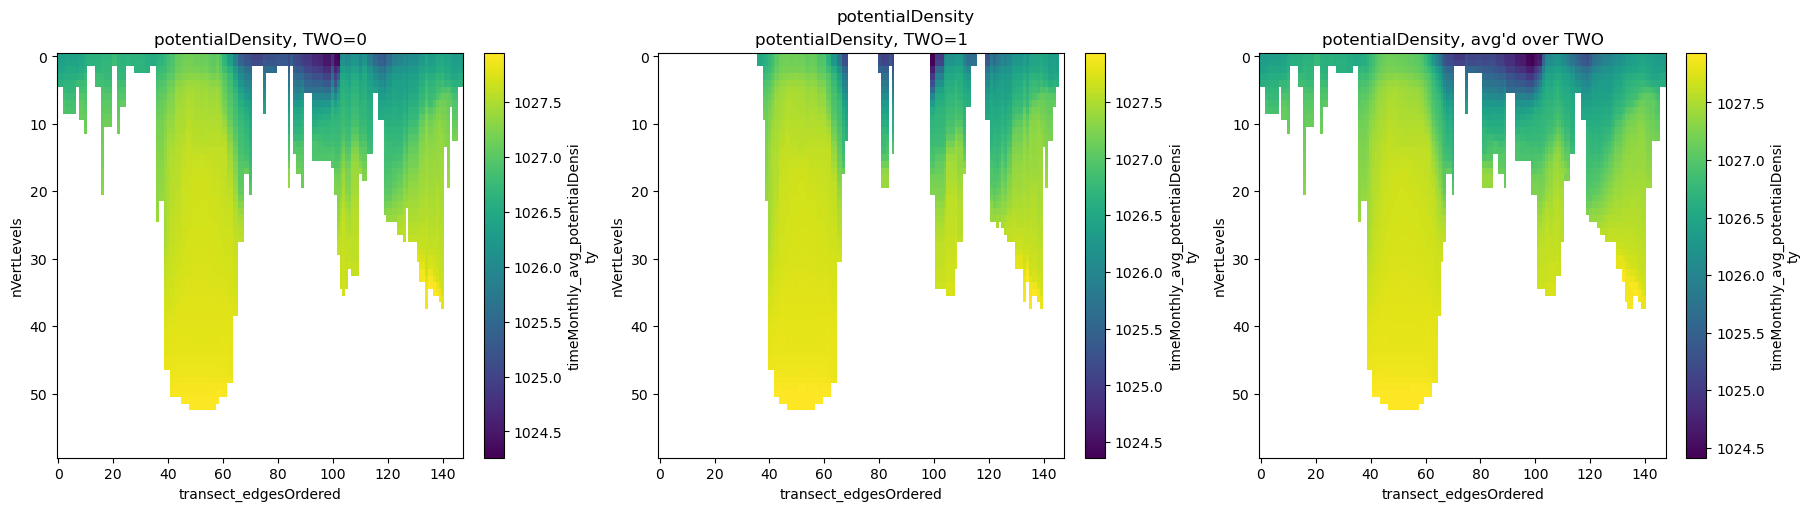

In [12]:
# plot density
fig, ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True, figsize=(18,5))

dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly']).isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[0])

dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly']).isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[1])

dss_transect_edges_NaNs.timeMonthly_avg_potentialDensity.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[2])


ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].set_title('potentialDensity, TWO=0')
ax[1].set_title('potentialDensity, TWO=1')
ax[2].set_title('potentialDensity, avg\'d over TWO')
fig.suptitle('potentialDensity')

Text(0.5, 0.98, 'layerThickness')

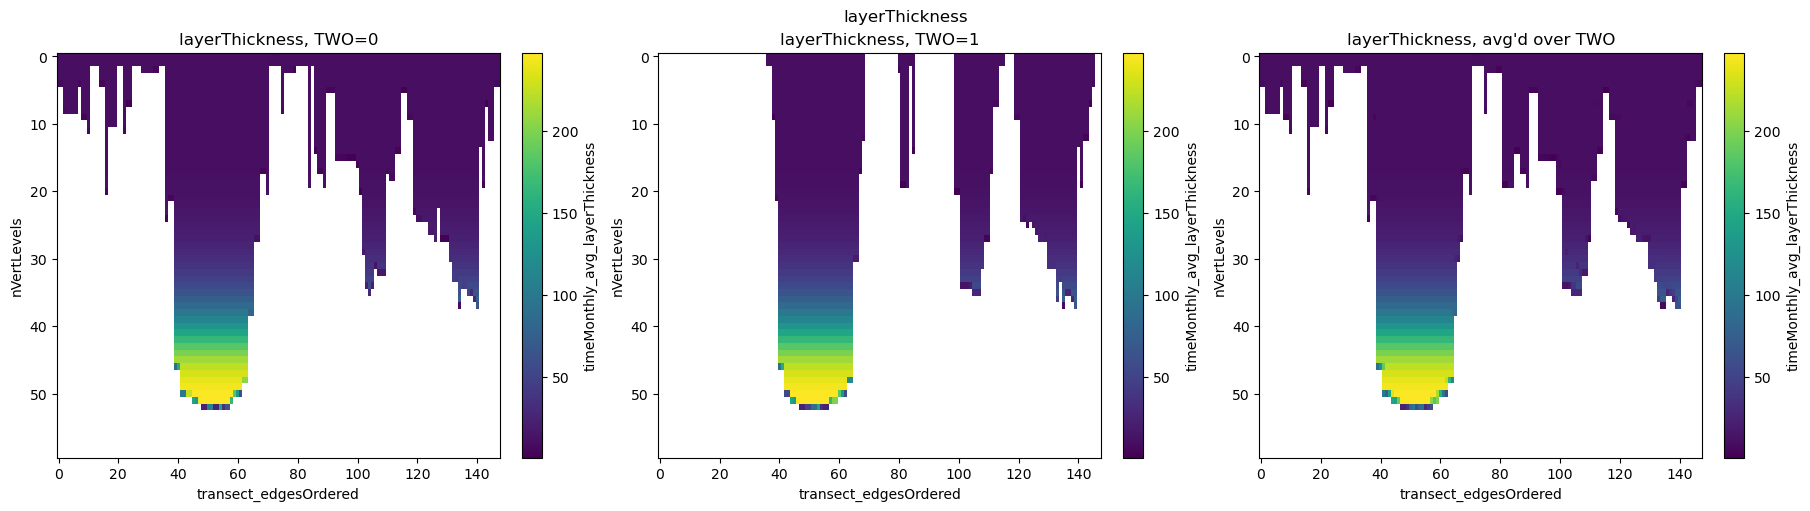

In [13]:
# plot layer thickness
fig, ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True, figsize=(18,5))

dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly']).isel(TWO=0).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[0])

dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly']).isel(TWO=1).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[1])

dss_transect_edges_NaNs.timeMonthly_avg_layerThickness.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels',ax=ax[2])


ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].set_title('layerThickness, TWO=0')
ax[1].set_title('layerThickness, TWO=1')
ax[2].set_title('layerThickness, avg\'d over TWO')
fig.suptitle('layerThickness')

In [14]:
dss_transect_edges_NaNs

<xarray.Dataset> Size: 3MB
Dimensions:                           (xtime_startMonthly: 12, nEdges: 148,
                                       nVertLevels: 60, TWO: 2,
                                       nVertLevelsP1: 61)
Coordinates: (12/35)
  * xtime_startMonthly                (xtime_startMonthly) |S64 768B b'0003-0...
    nCells                            (nEdges, TWO) int64 2kB 202047 ... 236852
  * nEdges                            (nEdges) int64 1kB 17579 539876 ... 17579
  * nVertLevels                       (nVertLevels) int64 480B 0 1 2 ... 58 59
  * nVertLevelsP1                     (nVertLevelsP1) int64 488B 0 1 2 ... 59 60
    latEdge                           (nEdges) float64 1kB 1.14 1.136 ... 1.14
    ...                                ...
    bottomDepth                       (nEdges, TWO) float64 2kB 47.44 ... 3.6...
    maxLevelCell                      (nEdges, TWO) int32 1kB 5 53 5 ... 53 5 53
    refBottomDepth                    (nVertLevels) float64 480B 10.0 ... 5.5...
    restingThickness                  (nEdges, TWO, nVertLevels) float64 142kB ...
    vertCoordMovementWeights          (nVertLevels) float64 480B 1.0 1.0 ... 1.0
    transect_edgesOrdered             (nEdges) int64 1kB 0 1 2 3 ... 145 146 147
Dimensions without coordinates: TWO
Data variables:
    timeMonthly_avg_normalVelocity    (xtime_startMonthly, nEdges, nVertLevels, TWO) float32 852kB ...
    timeMonthly_avg_potentialDensity  (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    timeMonthly_avg_layerThickness    (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      oma2u668tq

# calculate transport

## calculate velocity into mask

In [34]:
ds_transect_edges

<xarray.Dataset> Size: 2GB
Dimensions:                           (xtime_startMonthly: 12, nEdges: 148,
                                       nVertLevels: 60, nCells: 236853,
                                       nVertLevelsP1: 61, nVertices: 482371,
                                       TWO: 2, maxEdges: 7, maxEdges2: 14,
                                       vertexDegree: 3)
Coordinates: (12/52)
  * xtime_startMonthly                (xtime_startMonthly) |S64 768B b'0003-0...
  * nCells                            (nCells) int64 2MB 0 1 2 ... 236851 236852
  * nEdges                            (nEdges) int64 1kB 17579 539876 ... 17579
  * nVertLevels                       (nVertLevels) int64 480B 0 1 2 ... 58 59
  * nVertLevelsP1                     (nVertLevelsP1) int64 488B 0 1 2 ... 59 60
    latCell                           (nCells) float64 2MB ...
    ...                                ...
    maxLevelCell                      (nCells) int32 947kB ...
    refBottomDepth                    (nVertLevels) float64 480B ...
    restingThickness                  (nCells, nVertLevels) float64 114MB ...
    vertCoordMovementWeights          (nVertLevels) float64 480B ...
    simulationStartTime               |S64 64B ...
    transect_edgesOrdered             (nEdges) int64 1kB 0 1 2 3 ... 145 146 147
Dimensions without coordinates: nVertices, TWO, maxEdges, maxEdges2,
                                vertexDegree
Data variables:
    timeMonthly_avg_normalVelocity    (xtime_startMonthly, nEdges, nVertLevels) float32 426kB ...
    timeMonthly_avg_potentialDensity  (xtime_startMonthly, nCells, nVertLevels) float32 682MB ...
    timeMonthly_avg_layerThickness    (xtime_startMonthly, nCells, nVertLevels) float32 682MB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      oma2u668tq

In [35]:
dss_transect_edges_vIM

<xarray.Dataset> Size: 7MB
Dimensions:                                  (xtime_startMonthly: 12,
                                              nEdges: 148, nVertLevels: 60,
                                              TWO: 2, nVertLevelsP1: 61)
Coordinates: (12/35)
  * xtime_startMonthly                       (xtime_startMonthly) |S64 768B b...
    nCells                                   (nEdges, TWO) int64 2kB 202047 ....
  * nEdges                                   (nEdges) int64 1kB 17579 ... 17579
  * nVertLevels                              (nVertLevels) int64 480B 0 1 ... 59
  * nVertLevelsP1                            (nVertLevelsP1) int64 488B 0 ... 60
    latEdge                                  (nEdges) float64 1kB 1.14 ... 1.14
    ...                                       ...
    bottomDepth                              (nEdges, TWO) float64 2kB 47.44 ...
    maxLevelCell                             (nEdges, TWO) int32 1kB 5 53 ... 53
    refBottomDepth                           (nVertLevels) float64 480B 10.0 ...
    restingThickness                         (nEdges, TWO, nVertLevels) float64 142kB ...
    vertCoordMovementWeights                 (nVertLevels) float64 480B 1.0 ....
    transect_edgesOrdered                    (nEdges) int64 1kB 0 1 ... 146 147
Dimensions without coordinates: TWO
Data variables:
    timeMonthly_avg_normalVelocity           (xtime_startMonthly, nEdges, nVertLevels, TWO) float32 852kB ...
    timeMonthly_avg_potentialDensity         (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    timeMonthly_avg_layerThickness           (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    veloIntoMask                             (xtime_startMonthly, nEdges, nVertLevels, TWO) float32 852kB ...
    timeMonthly_avg_layerThickness_Edge      (xtime_startMonthly, nEdges, nVertLevels) float32 426kB ...
    transportIntoMask_Sv                     (xtime_startMonthly, nEdges, nVertLevels, TWO) float64 2MB ...
    timeMonthly_avg_potentialDensity_Edge    (xtime_startMonthly, nEdges, nVertLevels) float32 426kB ...
    timeMonthly_avg_potentialDensity_EdgeP1  (xtime_startMonthly, nEdges, nVertLevelsP1) float32 433kB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      oma2u668tq

In [15]:
def calculate_velo_into_mask(ds_transect_edges, global_ds, mask):
    ds_transect_edges['veloIntoMask'] = ds_transect_edges.timeMonthly_avg_normalVelocity * 0
    
    # .isel the mesh to only get the sorted edges on the transect (identified already in dss_transect_edges
    global_ds_transect_edges = global_ds.isel(nEdges = ds_transect_edges.nEdges)
    
    # find transect edges that border land using the cellsOnEdge variable from the mesh
    xr_transect_edgesOnLand_TWO0 = global_ds_transect_edges.nEdges.where(np.isin(global_ds_transect_edges.cellsOnEdge.isel(TWO=0),0))
    xr_transect_edgesOnLand_TWO1 = global_ds_transect_edges.nEdges.where(np.isin(global_ds_transect_edges.cellsOnEdge.isel(TWO=1),0))
    xr_transect_edgesOnLand = np.union1d(xr_transect_edgesOnLand_TWO0, xr_transect_edgesOnLand_TWO1)
    
    # find transect edges that border ocean (all transect edges NOT bordering land)
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand)
    
    # find the cells that lie on the transect open ocean edges
    n_transect_cellsOnOceanEdges = global_ds_transect_edges.cellsOnEdge
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_edges_inside, ignore_xr_vertices_inside = mps.xr_inside_mask_info(global_ds,mask)
    
    
    # determine if the normal velocity points into or out of the mask 
    for i in range(0,len(xr_transect_cellsOnOceanEdges)):
        for j in range(0,len(ds_transect_edges.xtime_startMonthly)):
            cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges = i)
            selectedEdge = np.int32(global_ds_transect_edges.nEdges.isel(nEdges = i))
            selectedMonth = ds_transect_edges.xtime_startMonthly.isel(xtime_startMonthly=j)
    
            if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is inside the mask
                ds_transect_edges.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)] = ds_transect_edges.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges = selectedEdge)] * -1
    
            elif cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is inside the mask
                ds_transect_edges.veloIntoMask.loc[dict(xtime_startMonthly = selectedMonth, nEdges = selectedEdge)] = ds_transect_edges.timeMonthly_avg_normalVelocity.loc[dict(xtime_startMonthly = selectedMonth, 
                                                                                                                                                         nEdges = selectedEdge)] * 1

    return ds_transect_edges, global_ds_transect_edges, xr_transect_cellsOnOceanEdges

In [16]:
dss_transect_edges_vIM, ds_transect_edges, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(dss_transect_edges_NaNs, ds, mask)


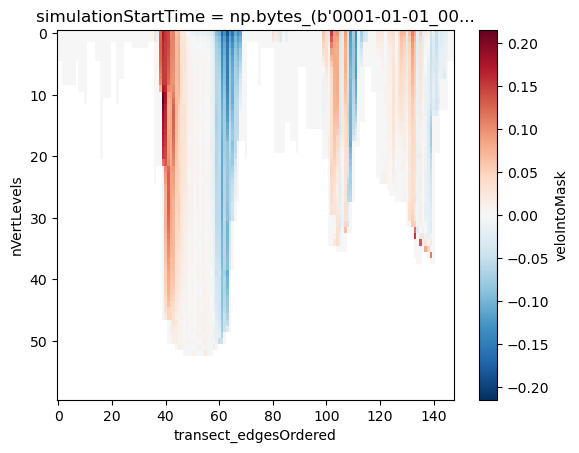

In [17]:
dss_transect_edges_vIM.veloIntoMask.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

## calculate the cross-sectional area of the grid cell

In [18]:
# calculate the area of the edge-layerThickness plane that the normal velocity moves through
# interpolate layer thickness onto nEdges
dss_transect_edges_vIM['timeMonthly_avg_layerThickness_Edge'] = dss_transect_edges_vIM.timeMonthly_avg_layerThickness.mean(dim='TWO')

# get the edge length for all edges in transect
ds_transect_edges_dv = ds_transect_edges.dvEdge

# calculate the cross-sectional area of the transect by multiplying the layer-thickness of the edge by the length of the edge
transect_area = dss_transect_edges_vIM.timeMonthly_avg_layerThickness_Edge * ds_transect_edges_dv

In [36]:
dss_transect_edges

<xarray.Dataset> Size: 56MB
Dimensions:                           (xtime_startMonthly: 12, nEdges: 148,
                                       nVertLevels: 60, TWO: 2,
                                       nVertLevelsP1: 61, nVertices: 482371,
                                       maxEdges: 7, maxEdges2: 14,
                                       vertexDegree: 3)
Coordinates: (12/52)
  * xtime_startMonthly                (xtime_startMonthly) |S64 768B b'0003-0...
    nCells                            (nEdges, TWO) int64 2kB 202047 ... 236852
  * nEdges                            (nEdges) int64 1kB 17579 539876 ... 17579
  * nVertLevels                       (nVertLevels) int64 480B 0 1 2 ... 58 59
  * nVertLevelsP1                     (nVertLevelsP1) int64 488B 0 1 2 ... 59 60
    latCell                           (nEdges, TWO) float64 2kB ...
    ...                                ...
    maxLevelCell                      (nEdges, TWO) int32 1kB ...
    refBottomDepth                    (nVertLevels) float64 480B ...
    restingThickness                  (nEdges, TWO, nVertLevels) float64 142kB ...
    vertCoordMovementWeights          (nVertLevels) float64 480B ...
    simulationStartTime               |S64 64B ...
    transect_edgesOrdered             (nEdges) int64 1kB 0 1 2 3 ... 145 146 147
Dimensions without coordinates: TWO, nVertices, maxEdges, maxEdges2,
                                vertexDegree
Data variables:
    timeMonthly_avg_normalVelocity    (xtime_startMonthly, nEdges, nVertLevels) float32 426kB ...
    timeMonthly_avg_potentialDensity  (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
    timeMonthly_avg_layerThickness    (xtime_startMonthly, nEdges, TWO, nVertLevels) float32 852kB ...
Attributes: (12/722)
    on_a_sphere:                                                  YES
    sphere_radius:                                                6.371229e+06
    model_name:                                                   mpas
    core_name:                                                    ocean
    history:                                                      mpirun -n 6...
    source:                                                       MPAS
    ...                                                           ...
    config_AM_harmonicAnalysis_use_K2:                            YES
    config_AM_harmonicAnalysis_use_K1:                            YES
    config_AM_harmonicAnalysis_use_O1:                            YES
    config_AM_harmonicAnalysis_use_Q1:                            YES
    config_AM_harmonicAnalysis_use_P1:                            YES
    file_id:                                                      oma2u668tq

In [ ]:
ds_transect_edges_dv = dss_transect

## calculate transport into the mask

In [19]:
transport = transect_area * dss_transect_edges_vIM.veloIntoMask / 10**6
dss_transect_edges_vIM['transportIntoMask_Sv'] = transport

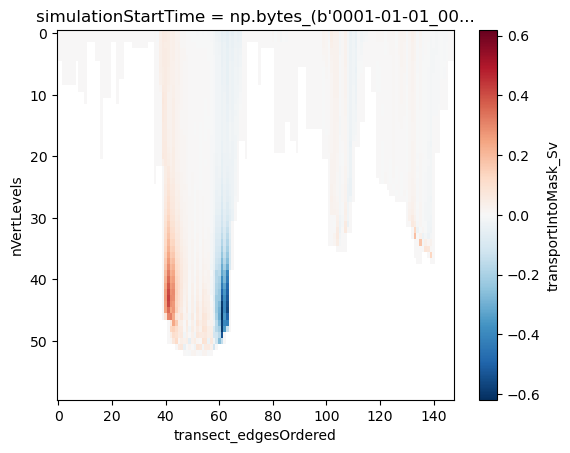

In [20]:
dss_transect_edges_vIM.transportIntoMask_Sv.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevels')
plt.gca().invert_yaxis()

### Visually check orientation of section makes sense with signs of velocities across the section

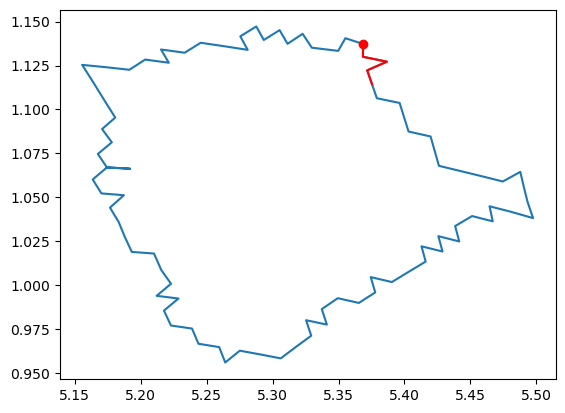

In [21]:
plt.plot(
    ds.lonCell.sel(nCells=xr_cellsOnTransectEdges.isel(TWO=0)),
    ds.latCell.sel(nCells=xr_cellsOnTransectEdges.isel(TWO=0)),
)
plt.plot(
    ds.lonCell.sel(nCells=xr_cellsOnTransectEdges.isel(TWO=0))[0],
    ds.latCell.sel(nCells=xr_cellsOnTransectEdges.isel(TWO=0))[0],
    "ro"
)

plt.plot(
    ds.lonCell.sel(nCells=xr_cellsOnTransectEdges.isel(TWO=0))[0:10],
    ds.latCell.sel(nCells=xr_cellsOnTransectEdges.isel(TWO=0))[0:10],
    "r-"
);

In [22]:
print('Total transport into mask: ', dss_transect_edges_vIM.transportIntoMask_Sv.sum().values)

Total transport into mask:  0.33458736734401384


# Since we want to look at transport per density class, we need to create density bins

## set up potential density so that it rests on nEdges and nVertLevelsP1

In [23]:
# now that we have transport calculated using an average of the TWO cells sitting on nEdges,
# we can do an ffill to replace all these nans with potentialDensity values of the last ocean cell above them
# this enables us to do an interpolation followed by an xgcm transorm to get transport by density class

# ffill (vertical direction), mean(dim='TWO') (get on nEdges instead of nCells)
dss_transect_edges_vIM['timeMonthly_avg_potentialDensity_Edge']= dss_transect_edges_vIM.timeMonthly_avg_potentialDensity.ffill(
    dim='nVertLevels',
    limit=1
).mean(dim='TWO')

# interpolate the potential density values onto nVertLevelsP1 coordinates
# create an xgcm grid
grid = Grid(dss_transect_edges_vIM, coords={'Z':{'center':'nVertLevels','outer':'nVertLevelsP1'}},periodic=False,autoparse_metadata=False)

# interpolate
dss_transect_edges_vIM['timeMonthly_avg_potentialDensity_EdgeP1'] = grid.interp(
    dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_Edge,
    'Z',
    boundary='extend'
)

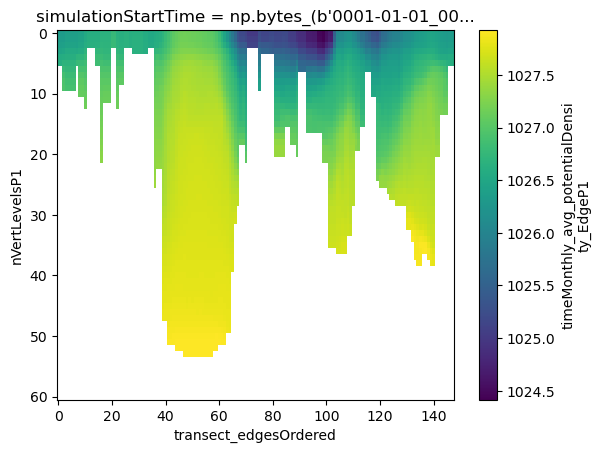

In [24]:
dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1.mean(dim='xtime_startMonthly').swap_dims({'nEdges':'transect_edgesOrdered'}).plot(y='nVertLevelsP1')
plt.gca().invert_yaxis()

In [25]:
print('min potential density: ', dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1.min().values)
print('max potential density: ', dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1.max().values)

min potential density:  1022.912353515625
max potential density:  1027.9373779296875


## use xgcm transform to convert from z coordinates to sigma coordinates

In [26]:
target_sigma = np.linspace(1022,1029,100)

# transform
transport_transformed_cons = grid.transform(dss_transect_edges_vIM.transportIntoMask_Sv,
                                            'Z',
                                            target_sigma,
                                            method='conservative',
                                            target_data = dss_transect_edges_vIM.timeMonthly_avg_potentialDensity_EdgeP1)

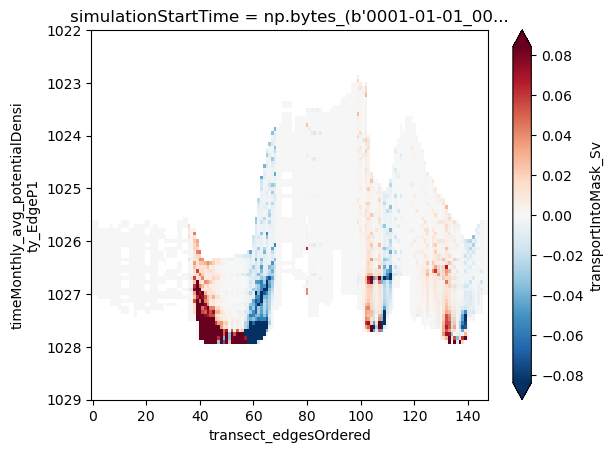

In [27]:
transport_transformed_cons.mean(dim=['xtime_startMonthly','TWO']).swap_dims({'nEdges':'transect_edgesOrdered'}).plot(x='transect_edgesOrdered', robust=True)
plt.gca().invert_yaxis()

In [28]:
total_transport_Edge = transport_transformed_cons.sum('nEdges').mean(dim=['xtime_startMonthly','TWO'])

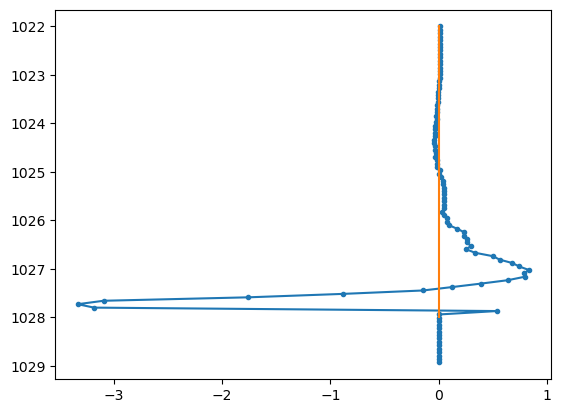

In [29]:
# we want to cumsum from bottom to top

# flip the array so bottom is now the first index
np.flipud(total_transport_Edge)

# cumsum this new array (this cumsums bottom (index=0) to top (index=49)
np.flipud(total_transport_Edge).cumsum()

# flip the array again to get cumsum bottom values back at the last index
cs_total_transport_Edge = np.flipud(np.flipud(total_transport_Edge).cumsum(axis=0))

plt.plot(cs_total_transport_Edge, target_sigma[0:99],marker='.')
plt.gca().invert_yaxis()
plt.plot(np.zeros(2), np.array([1022,1028]))